In [1]:
import pandas as pd

# open the file
with open("SMSSpamCollection.txt", 'r') as file_object:
    
    # Read the content
    content = file_object.readlines()

We can see that the flag and the message are separated by a tab ("\t") and each record is separated from each other by a break ("\n"), so we need to split the records to store them in a pandas dataframe.

In [2]:
# lists to store spam flags and messages after s
spam_flags = []
msgs = []
for row in content:
    row = row.strip("\n,")
    flag, msg = row.split('\t')
    spam_flags.append(flag)
    msgs.append(msg)

print("Number of flags in dataset: ", len(spam_flags))
print("Number of messages in dataset: ", len(msgs))

Number of flags in dataset:  5574
Number of messages in dataset:  5574


Since the amount of spam flags and messages are the same, we can create a dataframe from these 2 lists.

In [3]:
data = {'message': msgs, 'flag': spam_flags}
df = pd.DataFrame(data=data)
df.head()

,message,flag
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


We need to remove emoticons and convert emojis (if any) to words.

In [4]:
import re
try:
    import cPickle as pickle
except ImportError:
    import pickle

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text_list):
    for idx, text in enumerate(text_list):
        emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
        text = emoticon_pattern.sub(r'', text)
        text_list[idx] = text
    return text_list

with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text_list):
    for text in text_list:
        for emot in Emoji_Dict:
            text = re.sub(r'('+emot+')',"_".join(Emoji_Dict[emot].replace(',', '').replace(':','').split()), text)
    return text_list

In [5]:
# perform removal of emoticons and conversion of emojis to words
df['message'] = remove_emoticons(df['message'])
#df['message'] = convert_emojis_to_word(df['message'])

In [6]:
df.sample(10)

,message,flag
4489,Call me when you get the chance plz &lt;3,ham
4280,URGENT. Important information for 02 user. Tod...,spam
2673,Super msg danalla timing.,ham
470,There are many company. Tell me the language.,ham
3069,Boy you best get yo ass out here quick,ham
292,Haf u found him? I feel so stupid da v cam was...,ham
428,Any pain on urination any thing else?,ham
4071,Ok i wont call or disturb any one. I know all ...,ham
1296,TELL HER I SAID EAT SHIT.,ham
4670,"When I was born, GOD said, ""Oh No! Another IDI...",ham


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<AxesSubplot:>

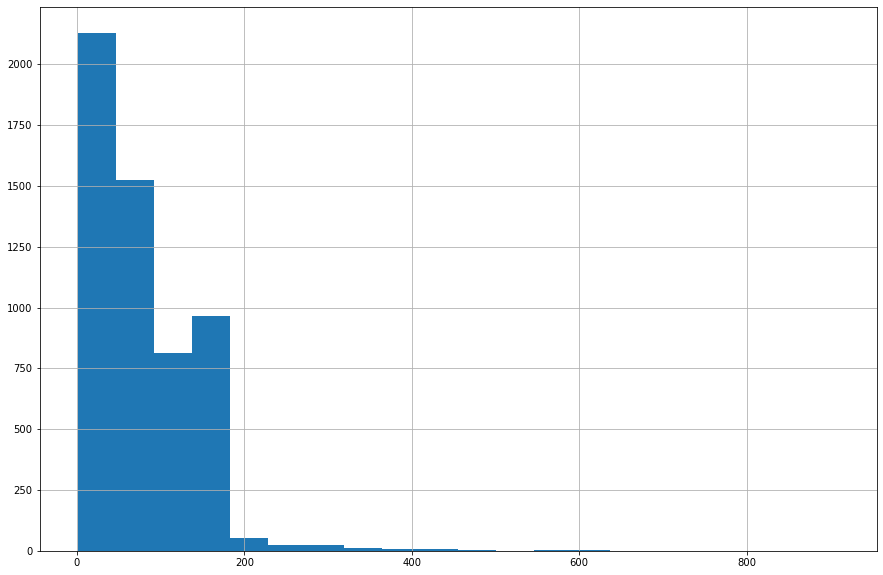

In [8]:
# plot length of message onto a histogram
df['message'].str.len().hist(bins=20, figsize=(15,10))

We can see that most SMS messages consist of fewer than 200 characters.

4824      0
3376      0
2509      1
276       1
4859      1
       ... 
2434    109
2158    125
2849    125
1863    162
1085    171
Name: message, Length: 5574, dtype: int64


<AxesSubplot:>

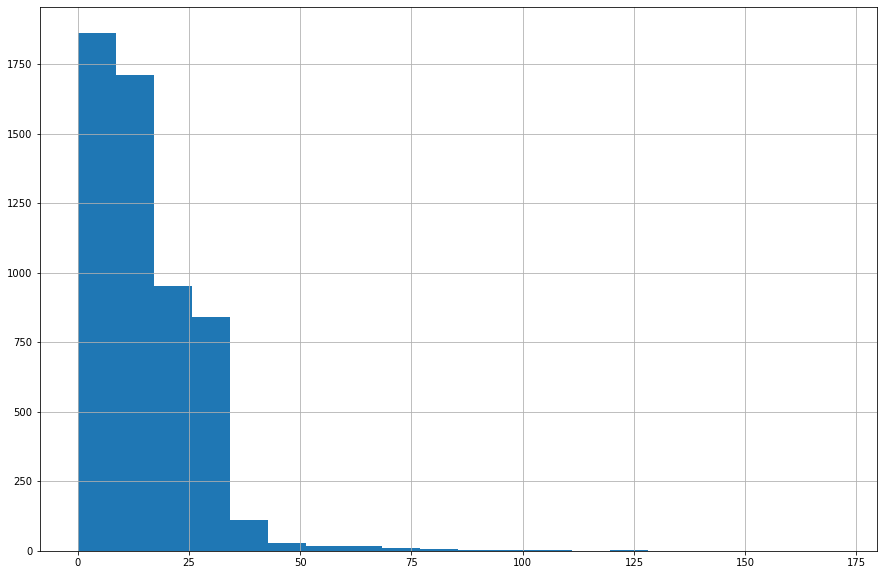

In [9]:
print(df['message'].str.split().map(lambda x: len(x)).sort_values())
df['message'].str.split().map(lambda x: len(x)).hist(bins=20, figsize=(15,10))

Most of the messages have 50 words or fewer, with a few outliers. The longest message has 171 words.

Next, let's check the average word length in each message.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3094    49.000000
3862    17.000000
5468    16.200000
2963    13.333333
1009    11.800000
2929    11.000000
4937    10.500000
4480    10.500000
346     10.333333
533     10.333333
Name: message, dtype: float64


<AxesSubplot:>

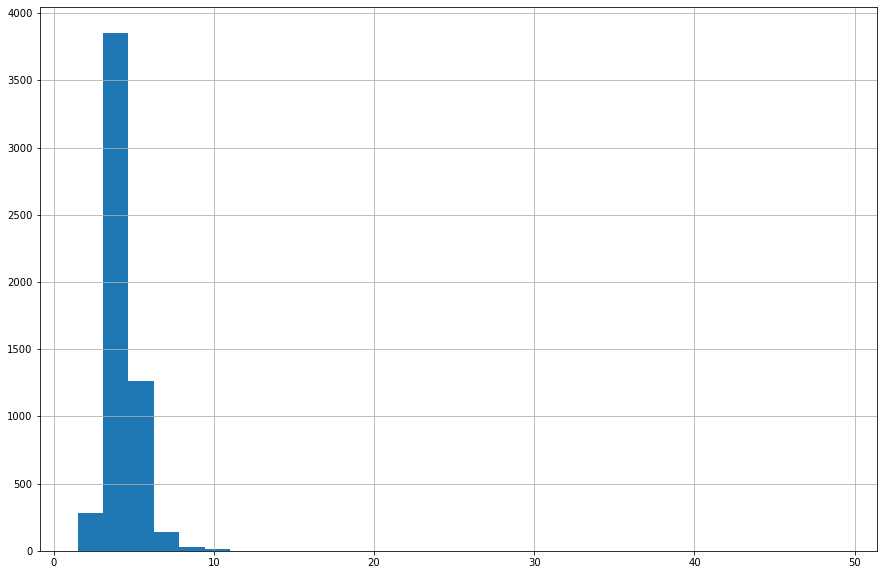

In [10]:
print(df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)).sort_values(ascending=False).head(10))
df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)).hist(bins=30, figsize=(15,10))

There is a message with an average word length of 49! Something must be off here. We'll examine the content of the message.

In [11]:
df.iloc[[3094]]

,message,flag
3094,staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323,ham


So this is a message containing a single URL. We can remove it as it doesn't really contain any words.

In [12]:
df.drop([3094], inplace=True)

We'll check the average word length of the messages again.

3862    17.000000
5468    16.200000
2963    13.333333
1009    11.800000
2929    11.000000
4937    10.500000
4480    10.500000
346     10.333333
533     10.333333
4703    10.000000
Name: message, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:>

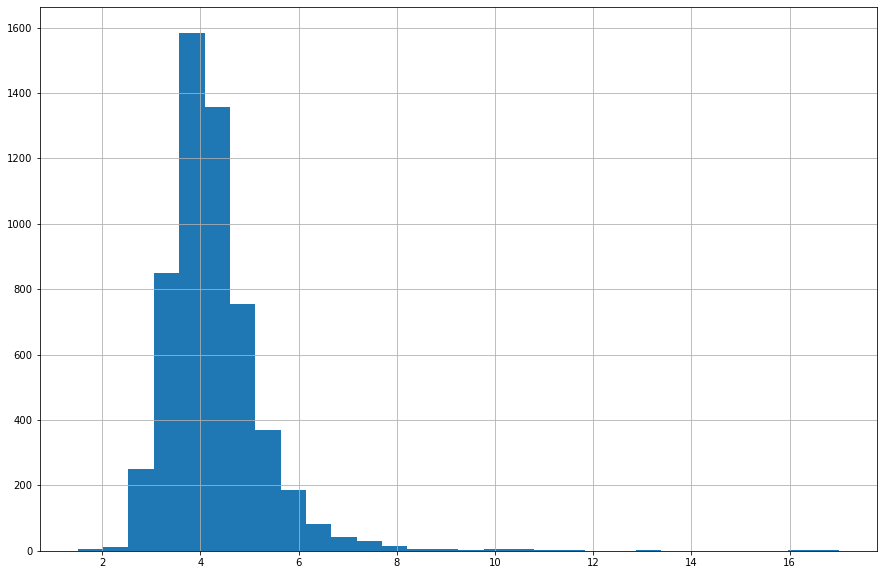

In [13]:
print(df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)).sort_values(ascending=False).head(10))
df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)).hist(bins=30, figsize=(15,10))

Without the outlier, the histogram looks much better, but it is still unusual for a message to have an average word length of 10 or greater.

In [14]:
df.loc[df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)) >= 10]

,message,flag
45,No calls..messages..missed calls,ham
326,No calls..messages..missed calls,ham
346,Gudnite....tc...practice going on,ham
533,Gudnite....tc...practice going on,ham
1009,"Poyyarikatur,kolathupalayam,unjalur post,erode...",ham
1988,No calls..messages..missed calls,ham
2929,Anything...,ham
2963,"""NONE!NOWHERE IKNO DOESDISCOUNT!SHITINNIT""",ham
3862,Free Msg: Ringtone!From: http/tms. widelive.co...,spam
4480,Erutupalam thandiyachu,ham


These messages are missing spaces after a punctuation or are also URLs. As there are only 14 records, we can also remove them.

In [15]:
df.drop(df.loc[df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)) >= 10].index, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
df.shape

(5560, 2)

As we can see from the query above of messages that contains more than 10 words, there are duplicate messages so we'll remove the duplicate records and keep only 1 copy.

In [17]:
df.drop_duplicates(inplace=True)
df.shape

(5159, 2)

More than 400 duplicate records were removed. We'll check to see how many messages belong to each category (spam vs. ham)

In [18]:
spam_count = df[df['flag']=='spam']['message'].count()
ham_count = df[df['flag']=='ham']['message'].count()
total_count = df['message'].count()

print('The number of spam messages is', df[df['flag']=='spam']['message'].count(), \
      'which account for {0:.2f}% of messages'.format(spam_count/total_count*100) )
print('The number of ham messages is', df[df['flag']=='ham']['message'].count(), \
      'which account for {0:.2f}% of messages'.format(ham_count/total_count*100))

The number of spam messages is 651 which account for 12.62% of messages
The number of ham messages is 4508 which account for 87.38% of messages


Messages might contain stopwords, which are words that are most commly used in any language such as "the", "a", "an", etc. These words might have resulted in the above graph being left-skewed, i.e. shorter words appear more frequently.

We'll now analyze these stopwords and their usage frequency in the dataset.

In [19]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

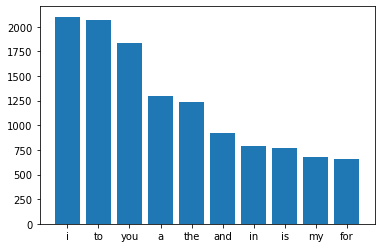

In [20]:
new= df['message'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word.lower() in stop:
        dic[word.lower()]+=1
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

So the top 3 stopwords used are 'i', 'to' and 'you'.

Let's inspect which other words are used frequently in each of the category.

<AxesSubplot:>

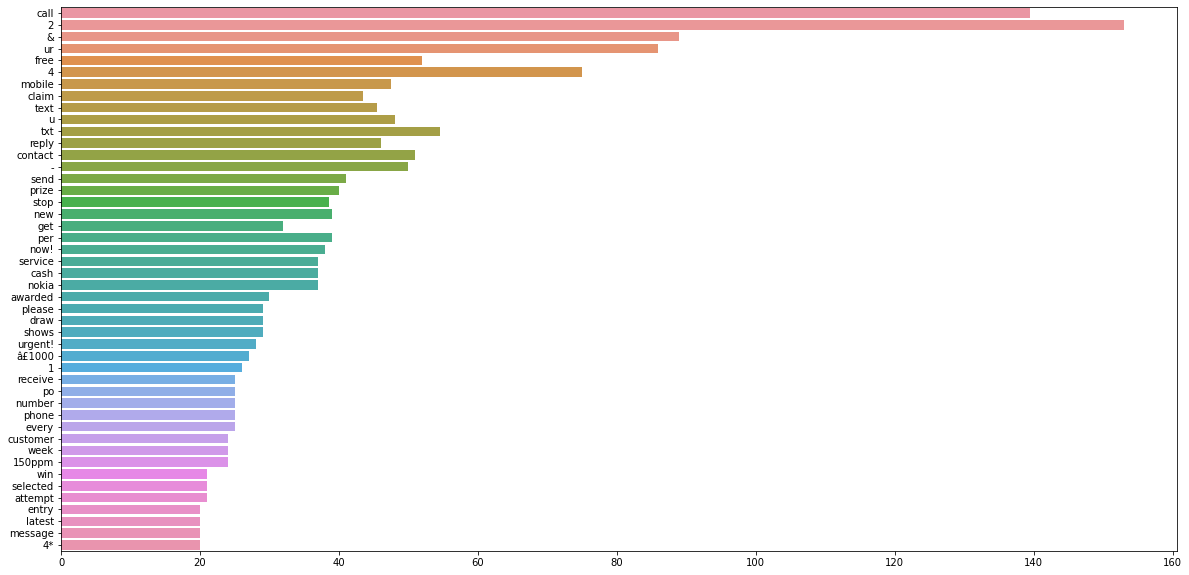

In [42]:
spam_words = df[df['flag']=='spam']['message'].str.split()
spam_words = spam_words.values.tolist()
spam_corpus = [word for i in spam_words for word in i]

from collections import Counter
spam_counter = Counter(spam_corpus)
spam_most = spam_counter.most_common()

x, y = [], []
for word,count in spam_most[:100]:
    if (word.lower() not in stop):
        x.append(count)
        y.append(word.lower())

plt.figure(figsize=(20,10))        
sns.barplot(x=x,y=y, ci=None)

<AxesSubplot:>

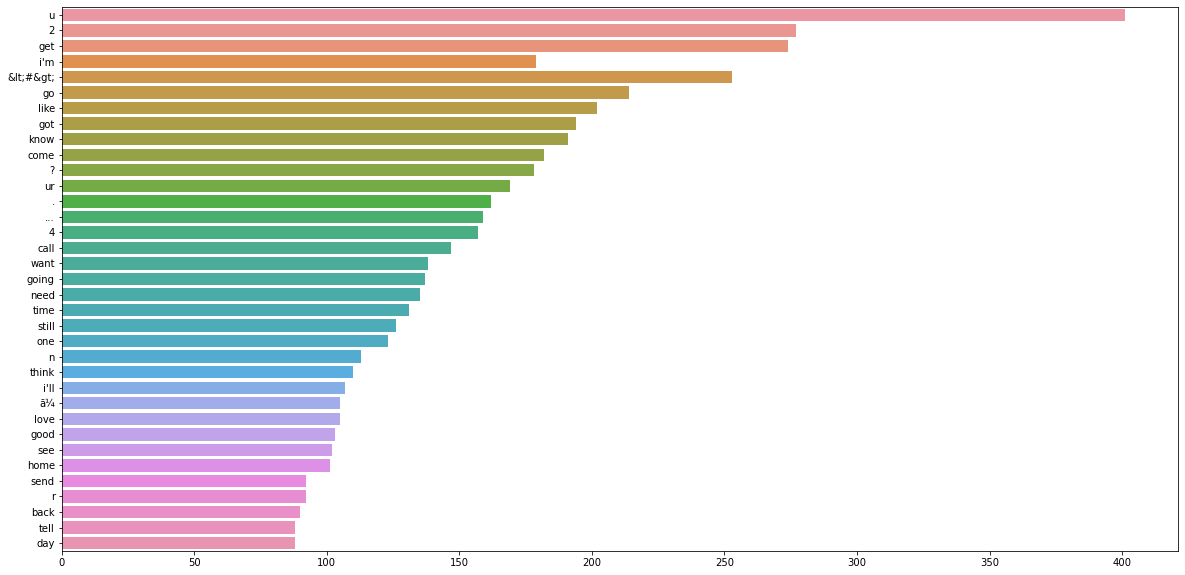

In [39]:
ham_words = df[df['flag']=='ham']['message'].str.split()
ham_words = ham_words.values.tolist()
ham_corpus = [word for i in ham_words for word in i]

from collections import Counter
ham_counter = Counter(ham_corpus)
ham_most = ham_counter.most_common()

x, y = [], []
for word,count in ham_most[:100]:
    if (word.lower() not in stop):
        x.append(count)
        y.append(word.lower())

plt.figure(figsize=(20,10))        
sns.barplot(x=x,y=y, ci=None)

# Ngram exploration

Here we look at combination of words that go together most frequently, in pairs or in groups of three.

In [45]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

<AxesSubplot:>

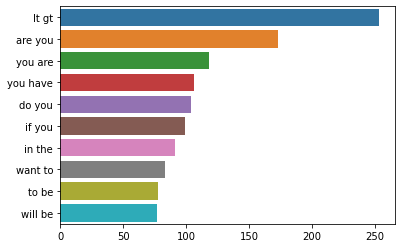

In [47]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

top_n_bigrams = get_top_ngram(df['message'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

<AxesSubplot:>

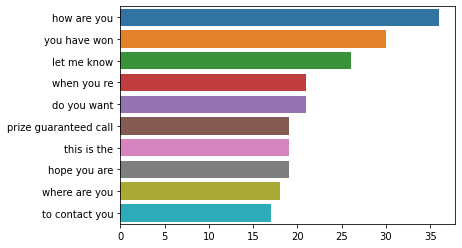

In [48]:
top_n_trigrams = get_top_ngram(df['message'],3)[:10] 
x,y=map(list,zip(*top_n_trigrams)) 
sns.barplot(x=y,y=x)

# Wordcloud

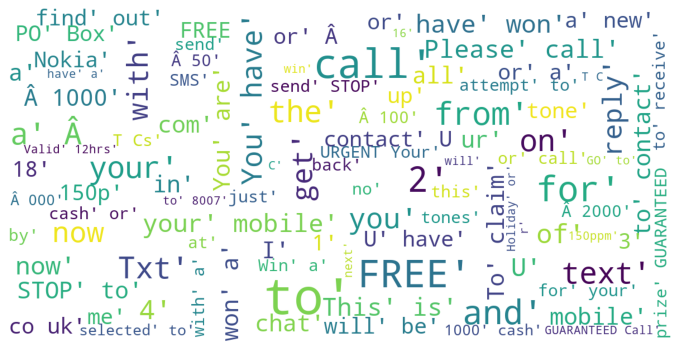

In [49]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(spam_corpus)

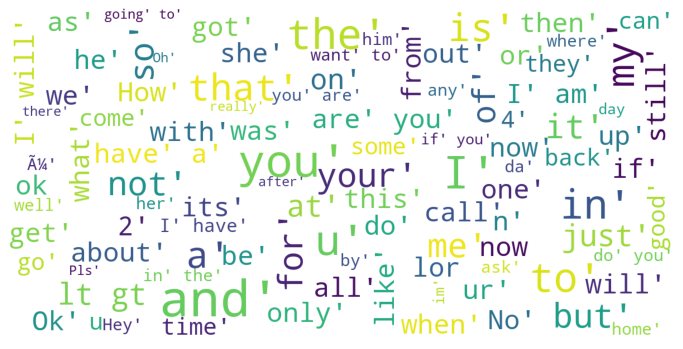

In [50]:
show_wordcloud(ham_corpus)

We can see that spam messages usually mention something "Free" or related to money ("cash", "win" or a number most likely to represent an amount of money), and call-to-action words like "call", "text", "txt".

On the other hand, ham messages do not have clear patterns and mostly consist of stopwords.

In [53]:
from library.sb_utils import save_file

# save the data to a new csv file
datapath = 'data'
save_file(df, 'SMSSpamCollection_cleaned.csv', datapath)

Directory data was created.
Writing file.  "data\SMSSpamCollection_cleaned.csv"
